In [10]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
# import adefc_vortex.fresnel_2dm as fresnel
# import adefc_vortex.fraunhofer_2dm as fraunhofer
import adefc_vortex.fresnel_2dm_96 as fresnel
import adefc_vortex.fraunhofer_2dm_96 as fraunhofer

wavelength_c = 650e-9

/home/kianmilani/Projects/adefc-vortex/adefc_vortex


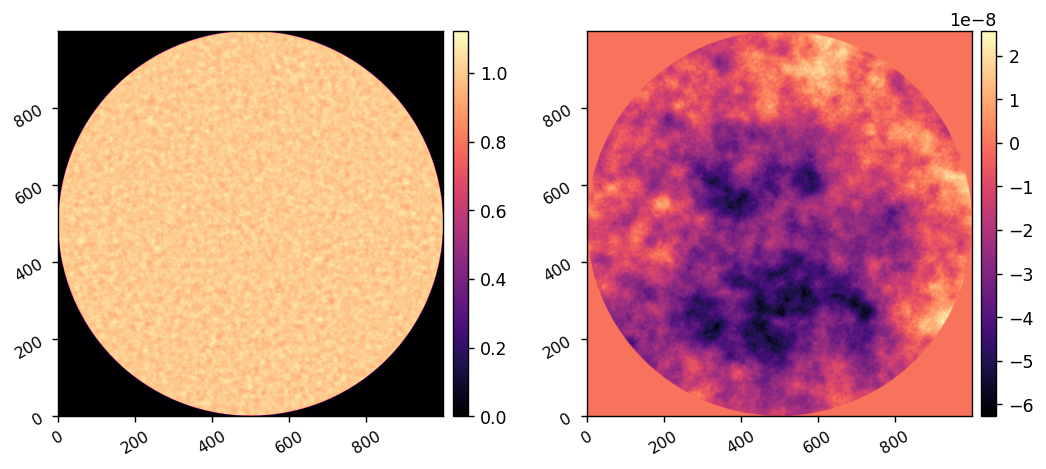

In [11]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

In [4]:
reload(fraunhofer)
M = fraunhofer.MODEL()

1.0
(7368,) <class 'numpy.ndarray'>


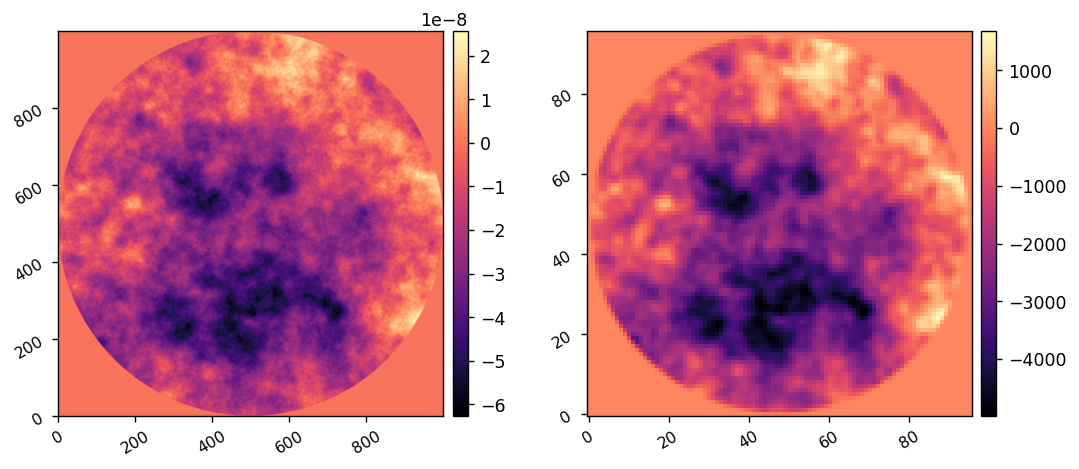

In [12]:
def val_and_grad(
    del_acts, 
    M, 
    OPD, 
    current_acts=np.zeros((M.Nact,M.Nact)) 
    ):
    del_acts = xp.array(del_acts)
    del_command = xp.zeros((M.Nact,M.Nact))
    del_command[M.dm_mask] = xp.array(del_acts[:M.Nacts//2])

    current_acts = xp.array(current_acts)

    dm1_command = current_acts + del_command
    dm1_mft = M.Mx@dm1_command@M.My
    dm1_surf_fft = M.inf_fun_fft * dm1_mft
    dm1_surf = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(dm1_surf_fft,))).real
    dm1_surf = utils.pad_or_crop(dm1_surf, M.npix)

    OPD = xp.array(OPD)
    opd_l2norm = OPD[M.APMASK].dot(OPD[M.APMASK])
    total_opd =  OPD + 2*dm1_surf
    J = total_opd[M.APMASK].dot(total_opd[M.APMASK]) / opd_l2norm
    print(J)

    masked_total = M.APMASK * total_opd
    dJ_dOPD = 2 * (masked_total) / opd_l2norm

    dJ_dS_DM1 = utils.pad_or_crop(dJ_dOPD, M.Nsurf)
    x2_bar = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(dJ_dS_DM1)))
    x1_bar = x2_bar * M.inf_fun_fft.conj()
    dJ_dA1 = M.Mx_back@x1_bar@M.My_back / ( M.Nsurf * M.Nact * M.Nact )

    dJ_dA = dJ_dA1[M.dm_mask].real

    return ensure_np_array(J), ensure_np_array(dJ_dA)

del_acts = xp.zeros(M.Nacts//2)
J0, dJ_dA = val_and_grad(del_acts, M, OPD)
print(dJ_dA.shape, type(dJ_dA))

dm_grad = xp.zeros((M.Nact, M.Nact))
dm_grad[M.dm_mask] = xp.array(dJ_dA)
imshow2(OPD, dm_grad)

In [56]:
M.Nacts//2

952

1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7368     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  4.99511D+03
2587711678763.856
0.961577745182298
0.9612053448733953
646927134929.2769
0.9242875303657588
0.9239297115635693
161731399110.68698
0.888457392363006
0.8881135837616707
40432661269.91651
0.8540300908125747
0.8536997431718244
10108072927.694462
0.820950565726603
0.8206331507372474
2526972950.804316
0.7891657983786827

At iterate    1    f=  7.89166D-01    |proj g|=  4.45628D+03
0.006620982901810248

At iterate    2    f=  6.62098D-03    |proj g|=  3.14900D+02
0.0059895576476806265

At iterate    3    f=  5.98956D-03    |proj g|=  1.55365D+02
0.005374679666618643

At iterate    4    f=  5.37468D-03    |proj g|=  6.08757D+01
0.005255398666546907

At iterate    5    f=  5.25540D-03    |proj g|=  5.01210D+01
0.005180089725976384

At iterate    6    f=  5.18009D-03

 This problem is unconstrained.


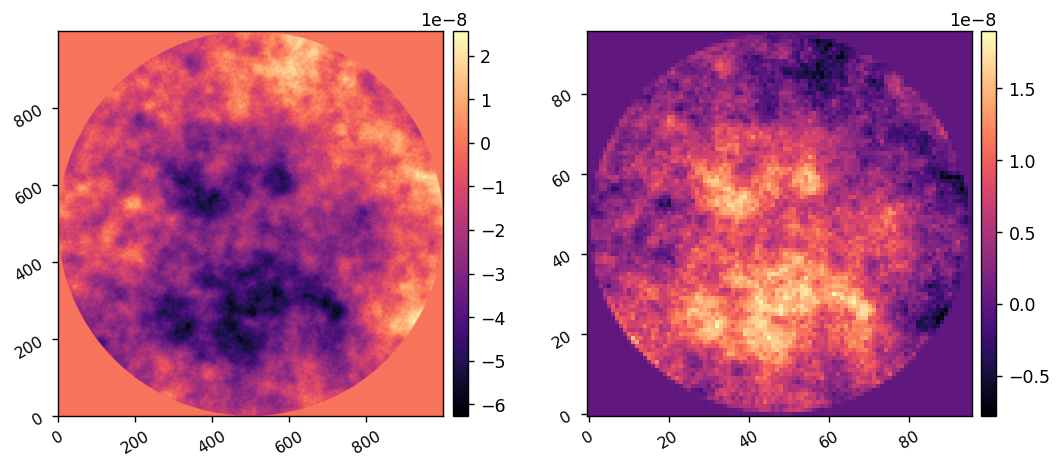

In [13]:
bfgs_tol = 1e-4
options = {
    'disp':True, 
    # 'maxiter':30,
    # 'maxls':100, # default is 20
    # 'ftol':1e-6, 
    # 'gtol':1e-6,
}
OPD = ensure_np_array(OPD)
del_acts0 = np.zeros(M.Nacts//2)
res = minimize(
    val_and_grad, 
    jac=True, 
    x0=del_acts0, 
    args=(M, OPD),
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=options,
)

min_command = xp.zeros((M.Nact, M.Nact))
min_command[M.dm_mask] = xp.array(res.x)
imshow2(OPD, min_command,)

In [14]:
utils.save_fits('../data/dm1_flat_command_96.fits', min_command)

Saved data to:  ../data/dm1_flat_command_96.fits
